In [95]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 

In [96]:
dataset_path =r'E:\work\masters\Trento\Academics\Semesters\Year 1 Semester 1\146069 Next Generation Networks\project\execution\data\Data\RTT_data.csv' 

In [97]:
RTT_data= pd.read_csv(dataset_path)

In [102]:
def estimate_range(selected_row_in):
    # We do range estimation for just one observation received as an argument
    selected_row = selected_row_in
    selected_data = RTT_data.iloc[selected_row] # Select row from dataset

    channels_begin = 11 # Channels start at column 11
    channel_batch_size =114 # Each antenna has 114 complex channel estimates

    channels_unpadded = selected_data[channels_begin:channels_begin+2*channel_batch_size]   # Select all channels for antenna 1

    np_channels = np.array(channels_unpadded) # Convert to numpy array 

    np_channels_cplx = np.zeros_like(np_channels) # Initialize a same-shape array 

    # Convert channels from string to complex
    counter = 0
    for ch_rsp in np_channels:
        ch_rsp= complex(ch_rsp.replace('i', 'j')) 
        np_channels_cplx[counter] = ch_rsp 
        counter+=1

    # Assign the complex channels to a new variable 

    channels_unpadded_raw = np_channels_cplx 

    # Add DC tones and guard subcarriers for 40MHz Wi-Fi
    sub_channel_batch_size = 57

    zeros_to_pad = 28 
    channels = np.zeros(2*channel_batch_size+28, dtype=complex)
    current_index = 6 
    channels[current_index:sub_channel_batch_size+current_index] = channels_unpadded_raw[:sub_channel_batch_size]
    current_index += (sub_channel_batch_size +3)
    channels[current_index:current_index+sub_channel_batch_size] = channels_unpadded_raw[sub_channel_batch_size:channel_batch_size]
    current_index += (sub_channel_batch_size+11)
    channels[current_index:current_index+sub_channel_batch_size] = channels_unpadded_raw[channel_batch_size:sub_channel_batch_size+channel_batch_size] 
    current_index += (sub_channel_batch_size+3)
    channels[current_index:current_index+sub_channel_batch_size] =  channels_unpadded_raw[sub_channel_batch_size+channel_batch_size:2*channel_batch_size]
    channels.shape

    # Client, AP channels
    channels_client = channels[:128]
    channels_ap = channels[128:] 

    # Convert to time domain using the inverse fast fourier transform 
    channels_timedomain = np.fft.ifft(np.fft.ifftshift(channels_client))
    channels_timedomain_ap = np.fft.ifft(np.fft.ifftshift(channels_ap))

    '''
    plt.plot(channels_timedomain.real, label='real')
    plt.plot(channels_timedomain.imag, '--',  label='imaginary')
    plt.title('Client') 
    plt.legend()
    plt.show()

    plt.plot(channels_timedomain_ap.real, label='real')
    plt.plot(channels_timedomain_ap.imag, '--',  label='imaginary') 
    plt.title('Access point')
    plt.legend()
    plt.show()

    
    plt.plot(np.abs(channels_timedomain))
    plt.xlabel('Time index')
    plt.ylabel('Channel Magnitude')
    plt.title('Channel magnitudes')
    '''    

    N_samples_to_shift = 13; # integer number of samples to circular shift
    channel_time_domain_circ_shifted = np.roll(channels_timedomain, N_samples_to_shift)
    channel_time_domain_circ_shifted_ap = np.roll(channels_timedomain_ap, N_samples_to_shift)

    '''
    plt.plot(channel_time_domain_circ_shifted.real, label='real')
    plt.plot(channel_time_domain_circ_shifted.imag, '--',  label='imaginary') 
    plt.title('Channels circular shifted')
    plt.legend()
    plt.show()

    plt.plot(channel_time_domain_circ_shifted_ap.real, label='real')
    plt.plot(channel_time_domain_circ_shifted_ap.imag, '--',  label='imaginary') 
    plt.title('AP channels circular shifted')
    plt.legend()
    plt.show()
    '''

    est_ToA_index_client = np.argmax(channel_time_domain_circ_shifted)

    est_ToA_index_AP = np.argmax(channel_time_domain_circ_shifted_ap)
    
    # Correct ToA indexes by -N_samples_to_shift
    est_ToA_index_client    = est_ToA_index_client - N_samples_to_shift
    est_ToA_index_AP        = est_ToA_index_AP - N_samples_to_shift

    # Translate the sample index to time in seconds
    # The channels are sampled at 40MHz. The entire symbol is 3.2usec length.
    delta_time_per_sample = 1/40e6 # time difference between each two samples (sec)
    est_ToA_client = (est_ToA_index_client - 1)*delta_time_per_sample  # estimated client ToA in seconds
    est_ToA_AP     = (est_ToA_index_AP - 1)*delta_time_per_sample      # estimated AP ToA in seconds

    print('Client ToA estimate:',est_ToA_client,'AP ToA estimate: ', est_ToA_AP)

    # Calculate estimated range and range error
    ToD_factor = selected_data['ToD_factor[m]'] # in meters RTT_data(:,ind.ToDfactor)
    est_range = ToD_factor + (est_ToA_client + est_ToA_AP)*3e8/2 # estimated range [m]
    GT_range = selected_data['GroundTruthRange[m]'] # ground truth range for this measurement [m]
    ml_range_estimate = selected_data['ML_range_estimate[m]']
    range_error = est_range - GT_range # estimated range error [m] 
    print('ToD factor',ToD_factor,'estimated range',est_range,'Ground truth range', GT_range, 'range error', range_error,'n','ML range estimate',ml_range_estimate)

    return est_range, GT_range,ml_range_estimate




In [108]:
true_range = []
ml_estimate = []
range_estimate = [] 

for i in range(1,102):
    [a,b,c] = estimate_range(i) 
    true_range.append(b)
    ml_estimate.append(c) 
    range_estimate.append(a)

Client ToA estimate: 2e-07 AP ToA estimate:  1e-07
ToD factor -8.7062 estimated range 36.2938 Ground truth range 23.051 range error 13.242799999999999 n ML range estimate 28.16
Client ToA estimate: 1.5e-07 AP ToA estimate:  1.25e-07
ToD factor 2.758 estimated range 44.008 Ground truth range 26.095 range error 17.913000000000004 n ML range estimate 33.169
Client ToA estimate: 3.2499999999999996e-07 AP ToA estimate:  1e-07
ToD factor -1.6769 estimated range 62.07309999999999 Ground truth range 31.047 range error 31.02609999999999 n ML range estimate 37.183
Client ToA estimate: 5e-08 AP ToA estimate:  5e-08
ToD factor 2.5511 estimated range 17.551099999999998 Ground truth range 23.051 range error -5.4999 n ML range estimate 27.092
Client ToA estimate: 2e-07 AP ToA estimate:  1.25e-07
ToD factor -4.5084 estimated range 44.24159999999999 Ground truth range 26.095 range error 18.146599999999992 n ML range estimate 29.71
Client ToA estimate: 2e-07 AP ToA estimate:  1e-07
ToD factor 5.794 esti

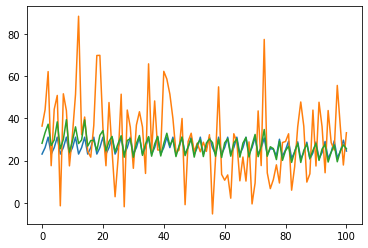

In [109]:
#true_range = []
#ml_estimate = []
#range_estimate = [] 

plt.plot(true_range)
plt.plot(range_estimate)
plt.plot(ml_estimate)